In [1]:
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io, color, transform

import cv2
import numpy as np
import os
import pandas as pd
import re

from PIL import Image
from sklearn.preprocessing import MinMaxScaler

# READ DATA

In [2]:
#data_train = pd.read_csv("/Users/lethanhtien/Desktop/run/data/train.csv")
data = pd.read_csv("dataset.csv")

# CHECK CLASS IMBALANCE

In [3]:
class_counts = data['label'].value_counts()
print(class_counts)

label
0    1000
1    1000
2    1000
3    1000
4    1000
Name: count, dtype: int64


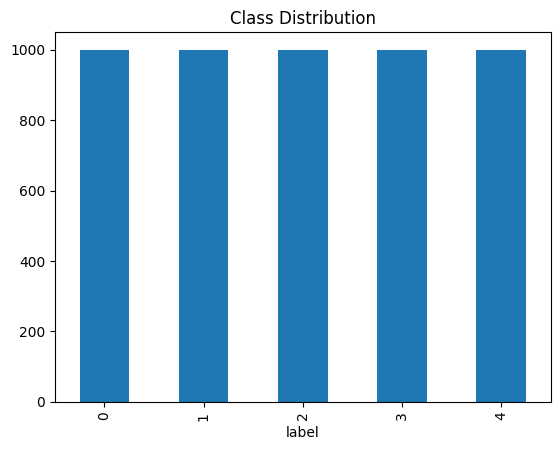

In [4]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cân bằng lớp
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()


In [5]:
total_samples = len(data)
class_ratios = class_counts / total_samples
print(class_ratios)


label
0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: count, dtype: float64


# SPLIT DATA

In [6]:
x = data.drop("label", axis=1)
y = data['label']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

In [8]:
X_train[0]

array([233, 233, 233, ..., 246, 249, 250], dtype=int64)

# SCALE DATA

In [9]:
# Khởi tạo mô hình MinMaxScaler và fit trên tập huấn luyện
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Sử dụng mô hình đã fit để chuẩn hóa tập kiểm tra
X_test_scaled = scaler.transform(X_test)

# TRAIN

In [10]:
from sklearn.svm import SVC
# Huấn luyện mô hình SVM với các tham số cụ thể
svm_model = SVC(C=0.1, gamma=0.1, kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train)

# Dự đoán nhãn trên tập kiểm tra
y_pred = svm_model.predict(X_test_scaled)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.63


# EVALUATE

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Tính precision, recall, và f1-score cho từng lớp
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

class_names = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad']

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}\n')

for i in range(len(class_names)):
    print(f"Class {class_names[i]}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")
    print()


Accuracy: 0.63

Class Angry:
  Precision: 0.5561
  Recall: 0.5278
  F1-Score: 0.5416

Class Fear:
  Precision: 0.5251
  Recall: 0.4947
  F1-Score: 0.5095

Class Happy:
  Precision: 0.7767
  Recall: 0.8333
  F1-Score: 0.8040

Class Neutral:
  Precision: 0.8191
  Recall: 0.7762
  F1-Score: 0.7971

Class Sad:
  Precision: 0.4692
  Recall: 0.5156
  F1-Score: 0.4913



# COMPARE WITH OTHERS

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Khởi tạo các mô hình
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=10000), 
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'Decision Tree': DecisionTreeClassifier()
}

# Huấn luyện và đánh giá các mô hình
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{name} - Cross-validation scores: {cv_scores}")
    print(f"{name} - Mean accuracy: {np.mean(cv_scores)}")


# TEST

In [ ]:
def test(path):
    # Đường dẫn của tấm ảnh
    image_path = path

    # Mở ảnh bằng Pillow
    img = Image.open(image_path)

    # Chuyển ảnh về ảnh trắng đen
    img = img.convert("L")

    # Chuyển ảnh thành mảng NumPy
    img_array = np.array(img)

    # Resize ảnh về kích thước mong muốn
    resized_img = cv2.resize(img_array, (48, 48))

    flattened_img = resized_img.flatten().reshape(-1, 1)
    # Chuẩn hóa ảnh
    scaler = MinMaxScaler()
    img1 = scaler.fit_transform(flattened_img).T

    y_pred = svm_model.predict(img1)

    return y_pred

In [ ]:
test("happy.jpg")

array([4], dtype=int64)

# SAVE MODEL

In [64]:
from joblib import dump
dump(svm_model, 'svm_model1.h5')

['svm_model2.h5']

# Tune

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Thiết lập các giá trị thử nghiệm cho C, kernel và gamma
param_grid = {'C': [0.1, 1, 10, 100, 10000],
              'kernel': ['linear', 'rbf'],
              'gamma': [0.1, 0.5, 5, 50]}

# Tạo mô hình SVM
svm_model = SVC()

# Sử dụng GridSearchCV để tìm kiếm qua lưới tham số
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Đánh giá mô hình trên tập kiểm tra
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Accuracy: 0.586


# INTERFACE


In [1]:
import gradio as gr
import numpy as np
from PIL import Image
from joblib import load
import dlib

svm_model = load('svm_model1.h5')

emotion_labels = {
    0: "Angry",
    1: "Fear",
    2: "Happy",
    3: "Neutral",
    4: "Sad",
}

# Sử dụng thư viện dlib để phát hiện khuôn mặt
detector = dlib.get_frontal_face_detector()

def predict_emotion(image):
    # Chuyển ảnh về numpy array
    img_array = np.array(image)

    # Convert về ảnh xám và resize về kích thước 48x48
    processed_image = Image.fromarray(img_array).convert('L').resize((48, 48))

    # Chuyển ảnh về mảng numpy
    processed_image_array = np.array(processed_image)

    # Chuẩn hóa ảnh
    flattened_img = processed_image_array.flatten().reshape(1, -1) / 255.0

    # Dự đoán nhãn của ảnh
    prediction = svm_model.predict(flattened_img)[0]

    # Phát hiện khuôn mặt trong ảnh
    faces = detector(img_array, 1)
    
    if len(faces) == 0:
        cropped_face = img_array
    else:
        # Cắt khuôn mặt từ ảnh gốc
        x, y, w, h = faces[0].left(), faces[0].top(), faces[0].width()+10, faces[0].height()+10
        cropped_face = img_array[y:y+h, x:x+w]

    return emotion_labels[prediction], cropped_face


iface = gr.Interface(
    fn=predict_emotion,
    inputs="image",
    outputs=["text", "image"],  
    title="Emotion Detection",
    description="Tải lên một ảnh để nhận dạng cảm xúc.",
    allow_flagging= False,
)

iface.launch(share = True)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\interface.py:317: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py", line 3095, in fromarray
    mode, rawmode = _fromarray_typemap[typekey]
                    ~~~~~~~~~~~~~~~~~~^^^^^^^^^
KeyError: ((1, 1), '|O')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\queueing.py", line 495, in call_prediction
    output = await route_utils.call_process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
       